In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import mean

In [3]:
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

In [10]:
# find tables within dataframe
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# find column names in Measurements
m_cols = inspector.get_columns('Measurement')
for c in m_cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# view measurement head
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# find column names in Station
s_cols = inspector.get_columns('Station')
for c in s_cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# view station data
engine.execute('SELECT * FROM Station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

### Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# find most recent date in database & sort by date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [16]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [17]:
# Perform a query to retrieve the data and precipitation scores
precip_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').\
    order_by(Measurement.date).all()


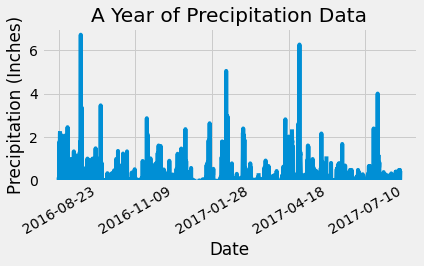

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip_year, columns= ['date', 'precipitation'])
df.set_index('date', inplace=True)
df.plot(rot=90, legend=False)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(rotation=30)
plt.title("A Year of Precipitation Data")
plt.subplots_adjust(bottom=0.35)
plt.ylim(0,7)
plt.savefig('images/precipitation.png')


In [19]:
# summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# count total stations in dataset
total_stations = session.query(Station.name).count()
print(total_stations)

9


In [21]:
# find most active stations and list in descending order
test = session.query(Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for result in test:
    print(result)

('WAIHEE 837.5, HI US', 2772)
('WAIKIKI 717.2, HI US', 2724)
('KANEOHE 838.1, HI US', 2709)
('WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('MANOA LYON ARBO 785.2, HI US', 2612)
('KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('HONOLULU OBSERVATORY 702.2, HI US', 1979)
('PEARL CITY, HI US', 1372)
('UPPER WAHIAWA 874.3, HI US', 511)


In [22]:
# Using the station id -- Waihee -- from the previous query, calculate the lowest temperature 
# recorded, highest temperature recorded, and average temperature
sel = [Station.name, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

waihee_data = session.query(*sel).\
    filter(Station.station == "USC00519281").\
    filter(Measurement.station == "USC00519281").all()
print(waihee_data)


[('WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]


In [23]:
# Query the last 12 months of temperature observation data for Waihee and plot the 
# results as a histogram
waihee_year = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').\
    order_by(Measurement.date).all()

waihee_df = pd.DataFrame(waihee_year)
waihee_df.set_index('date', inplace=True)
waihee_df



,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


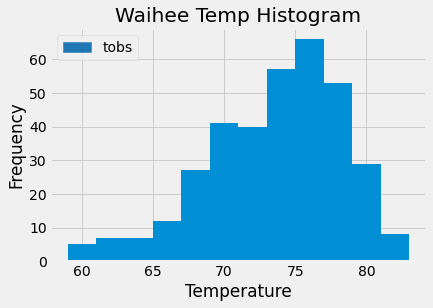

In [24]:
# create histogram of Waihee temp data
import matplotlib.patches as mpatches
waihee_df.hist(column='tobs', grid=True, bins=12)
blue_patch = mpatches.Patch(color='#1f77b4', label='tobs')
plt.legend(handles=[blue_patch], loc="upper left")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Waihee Temp Histogram")
plt.savefig('images/temp_histogram.png')

## more queries and further analysis

In [25]:
# Find the average temperature in June using all data
sel = [
      func.avg(Measurement.tobs)]

june_avgs = session.query(*sel).\
    filter(func.strftime('%m', Measurement.date) == '06').\
    filter(Measurement.station == Station.station).\
    group_by(Station.name).\
    order_by(Station.name).all()
june_avgs


[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [26]:
# Find the average temperature in Dec using all data

sel = [
      func.avg(Measurement.tobs)]

dec_avgs = session.query(*sel).\
    filter(func.strftime('%m', Measurement.date) == '12').\
    filter(Measurement.station == Station.station).\
    group_by(Station.name).\
    order_by(Station.name).all()
dec_avgs


[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [27]:
# Use the t-test to determine whether the difference in the means, if any, 
# is statistically significant - use paired because I want to compare the averages by station.
stats.ttest_rel(june_avgs, dec_avgs)

Ttest_relResult(statistic=array([6.95696617]), pvalue=array([0.00011759]))

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use calc_temps to calculate the tmin, tavg, and tmax 
# for trip using the previous year's data for those same dates.
results = calc_temps('2017-02-28', '2017-03-05')
results


[(64.0, 72.02777777777777, 78.0)]

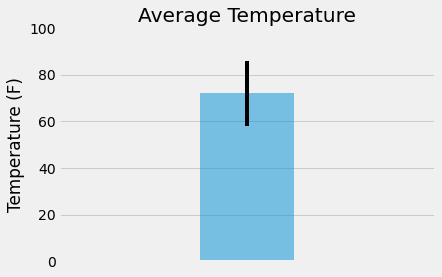

In [30]:
# Plot the results from previous query as a bar chart. 
temps = list(np.ravel(results))
label = ["average temperature"]
error = temps[2] - temps[0]
errors = [0, error, 0]
y_pos = [0, 1, 2]


plt.bar(0, temps[1], yerr=error, alpha=0.5, align="center", width=0.5)
plt.ylabel("Temperature (F)")
plt.ylim(0,100)
plt.xlim(-1, 1)
plt.title("Average Temperature")
plt.xticks([], [])
plt.savefig('images/avg_temp.png')


### further analysis (incomplete)

In [31]:
# Calculate the total amount of rainfall per weather station for trip dates using the 
# previous year's matching dates. Sort  in descending order by precipitation amount and list the 
# station, name, latitude, longitude, and elevation


def calc_rain(start_date, end_date):
    return session.query(func.min(Measurement.prcp), func.avg(Measurement.prcp), func.max(Measurement.prcp)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_rain('2017-02-28', '2017-03-05'))


[(0.0, 0.6599999999999998, 2.4)]


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip

def daily_normals(start_date, end_date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) >= start_date).\
    filter(func.strftime("%m-%d", Measurement.date) <= end_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
    
normals = daily_normals("02-28", "03-05")

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:
datelist = pd.date_range(dt.date(2017, 2, 28), periods=100).tolist()


In [35]:
import datetime as datetime
start = datetime.datetime.strptime("28-02", "%d-%m")
end = datetime.datetime.strptime("06-03", "%d-%m")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

for date in date_generated:
    print(date)

1900-02-28 00:00:00
1900-03-01 00:00:00
1900-03-02 00:00:00
1900-03-03 00:00:00
1900-03-04 00:00:00
1900-03-05 00:00:00


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [37]:
# Plot the daily normals as an area plot with `stacked=False`
